In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from PIL import Image
import os
import collections


In [ ]:
#number of classes in the cifar10 data set
NUM_CLASSES = 10

CLASS_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

CINIC_TEST_DIR = 'data/custom_test_images_from_cinic10/test'

### Data Sources

#### CIFAR-10: Training and Initial Testing Data
The CIFAR-10 dataset is a widely recognized benchmark in computer vision for image classification. It consists of 60,000 32x32 pixel color images categorized into 10 distinct classes. Each class contains 6,000 images, equally split into 50,000 images for the training set and 10,000 images for the test set.

The 10 classes are as follows:

1. airplane
2. automobile
3. bird
4. cat
5. deer
6. dog
7. frog
8. horse
9. ship
10. truck

For this project, CIFAR-10 serves as the primary dataset for training the base model and the transfer-learned architectures (ResNet50V2, DenseNet121, MobileNetV2, EfficientNetB0) and for their in-training validation.

### CINIC-10: Independent Performance Evaluation Data

[CINIC-10](https://https://www.kaggle.com/datasets/mengcius/cinic10) an extensive dataset designed as a "bridge" between CIFAR-10 and the much larger ImageNet dataset. It comprises a total of 270,000 images, which is 4.5 times larger than CIFAR-10. These images are also 32x32 pixels color images and belong to the same 10 classes as CIFAR-10. The dataset is constructed by combining all images from CIFAR-10 with a selection of downsampled images from the ImageNet database.

CINIC-10 is equally split into three subsets: training, validation, and test, each containing 90,000 images. Within each subset, there are 9,000 images per class.

For this project, **500 images of CINIC-10 test set of every class**  will be used to evaluate the final performance of the models trained on CIFAR-10. This allows us to assess how well the models generalize to a broader and potentially more diverse set of unseen images, which is critical for real-world application where data distribution might subtly shift. This setup helps to expose potential overfitting to the CIFAR-10 training data and provides a more robust measure of the models' true generalization capabilities.


### Exploratory Data Analysis of the cifar10 data set.

Loading:  CIFAR-10 database consists of 50,000 training images and 10,000 test images, each 32×32 pixels in size with three color channels (RGB).

Shape: (50000, 32, 32, 3) for the training images indicates a dataset of 50,000 images, each 32×32 pixels with 3 color channels.  (10000, 32, 32, 3) for the test images indicates a dataset of 10,000 images, each 32×32 pixels with 3 color channels.

Loading: 5000 test images for performance evaluation after training of shape (32, 32, 3)

**Class Distribution Analysis**

The CIFAR-10 dataset exhibits a perfectly balanced class distribution. Each of the 10 classes contains an equal number of samples: 5,000 images per class in the training set and 1,000 images per class in the test set. This balance simplifies initial model training as it prevents bias towards any particular class due to unequal representation.

**Pixel Intensity Distribution**

Analysis of pixel intensity provides insight into the raw value range and distribution across color channels. Histograms are generated for the Red, Green, and Blue color channels by flattening the image arrays and plotting the frequency of pixel intensity values (ranging from 0 to 255). For CIFAR-10, we typically observe a relatively even distribution of pixel values across all three channels, indicating a good spread of color information without heavy skewing towards very dark or very bright images.

When the pixel intensity distribution is not uniform across an image dataset, it can impact the training covergence time and the performance of Convolutional Neural Networks (CNNs).


**Sample Image Visualization**

 This is a sanity check to ensure the images are loaded correctly and the labels match the images. It also gives you a visual feel for the type and quality of the data your model will be trained on.






In [ ]:
# Function to perform and plot EDA for a given dataset
# skip_pixel_intensity_plot is added to run this function quickly during
# development as plotting pixel intensity takes a lot of time.
def perform_eda(images, labels, title_prefix, skip_pixel_intensity_plot = False):
    """
    Performs Exploratory Data Analysis by plotting class distribution,
    pixel intensity, and a grid of sample images.
    """
    # Flatten the labels for easier counting
    labels_flat = labels.flatten()
    class_counts = collections.Counter(labels_flat)

    # Print the class distribution
    print(f"\nClass distribution for {title_prefix} set:")
    sorted_labels = sorted(class_counts.keys())
    for i in sorted_labels:
        print(f"  - {CLASS_NAMES[i]}: {class_counts[i]} samples")

    # Plot the class distribution
    plt.figure(figsize=(10, 5))
    sns.barplot(x=CLASS_NAMES, y=[class_counts[i] for i in sorted_labels])
    plt.title(f'Class Distribution of {title_prefix} Images')
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    print("\nPlotting Pixel Intensity ... this will take time")
    #skip pixel intensity plot if needed
    if(skip_pixel_intensity_plot == False):
      # Plot the pixel intensity distribution for each color channel
      fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
      fig.suptitle(f'Pixel Intensity Distribution ({title_prefix} Set)', fontsize=16)
      colors = ['red', 'green', 'blue']
      channel_names = ['Red', 'Green', 'Blue']

      # Check if images have the correct shape before plotting
      if images.shape[-1] == 3:
        for i in range(3):
            sns.histplot(images[:, :, :, i].flatten(), color=colors[i], bins=50, ax=axes[i], kde=True)
            axes[i].set_title(f'{channel_names[i]} Channel')
            axes[i].set_xlabel('Pixel Intensity Value')
            axes[i].set_ylabel('Frequency' if i == 0 else '')
        plt.tight_layout()
        plt.show()

    # Display a grid of sample images with their labels
    print(f"\nDisplaying a sample of {title_prefix} images:")
    plt.figure(figsize=(10, 10))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i].astype('uint8')) # Cast back to uint8 for proper display
        # Make sure the label index is an integer for indexing CLASS_NAMES
        plt.xlabel(CLASS_NAMES[labels[i][0]])
    plt.show()


In [ ]:
#load CIFAR-10 data using the keras library
(train_images_eda, train_labels_eda), (test_images_eda, test_labels_eda) = keras.datasets.cifar10.load_data()

# Print the shapes of the data to see the dimensions.
print(f"Training images shape: {train_images_eda.shape}")
print(f"Training labels shape: {train_labels_eda.shape}")
print(f"Test images shape: {test_images_eda.shape}")
print(f"Test labels shape: {test_labels_eda.shape}")





Training images shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test images shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)



Class distribution for CIFAR-10 Training set:
  - airplane: 5000 samples
  - automobile: 5000 samples
  - bird: 5000 samples
  - cat: 5000 samples
  - deer: 5000 samples
  - dog: 5000 samples
  - frog: 5000 samples
  - horse: 5000 samples
  - ship: 5000 samples
  - truck: 5000 samples


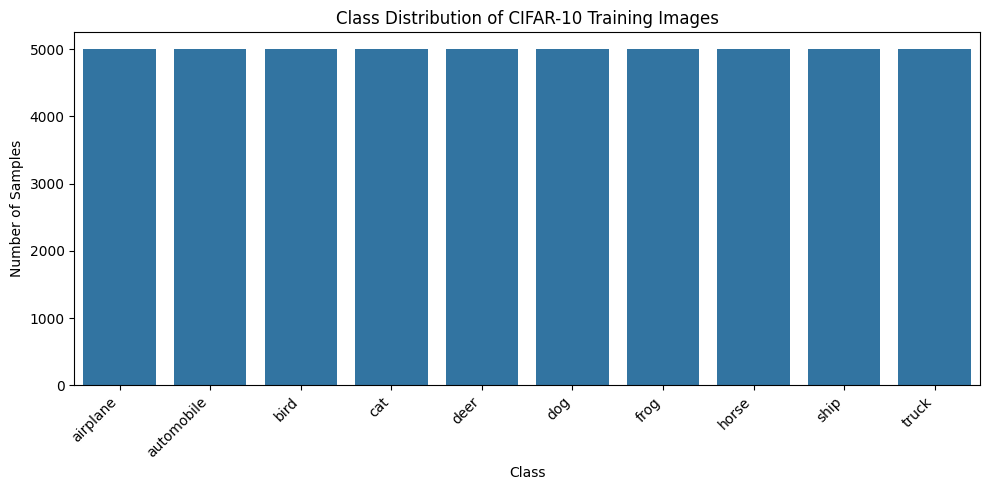


Plotting Pixel Intensity ... this will take time


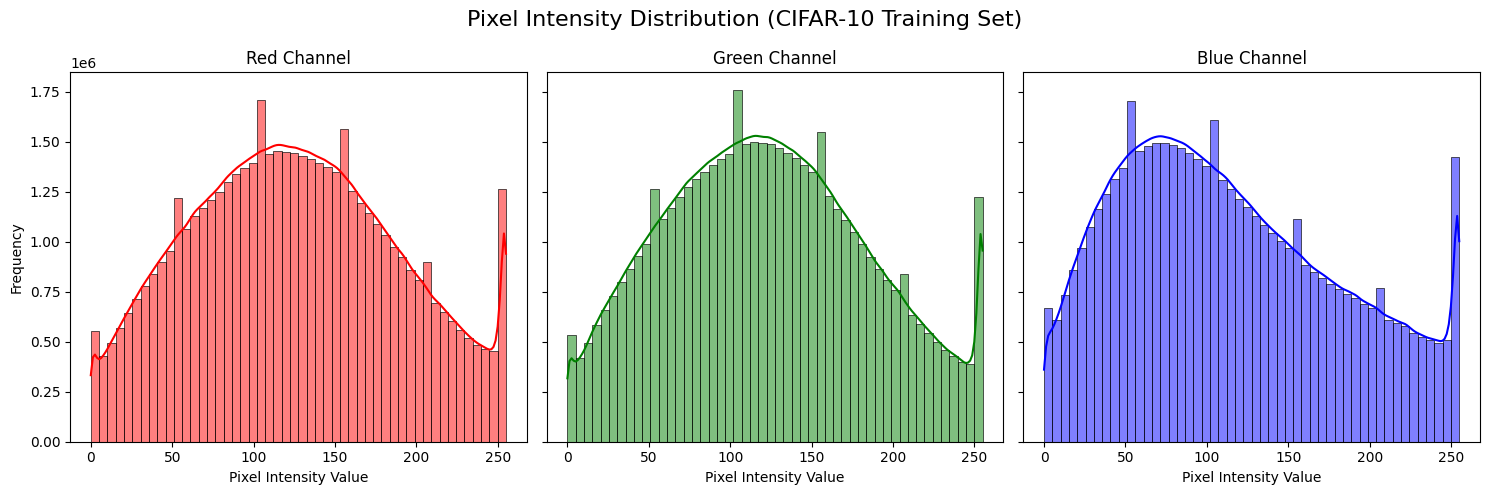


Displaying a sample of CIFAR-10 Training images:


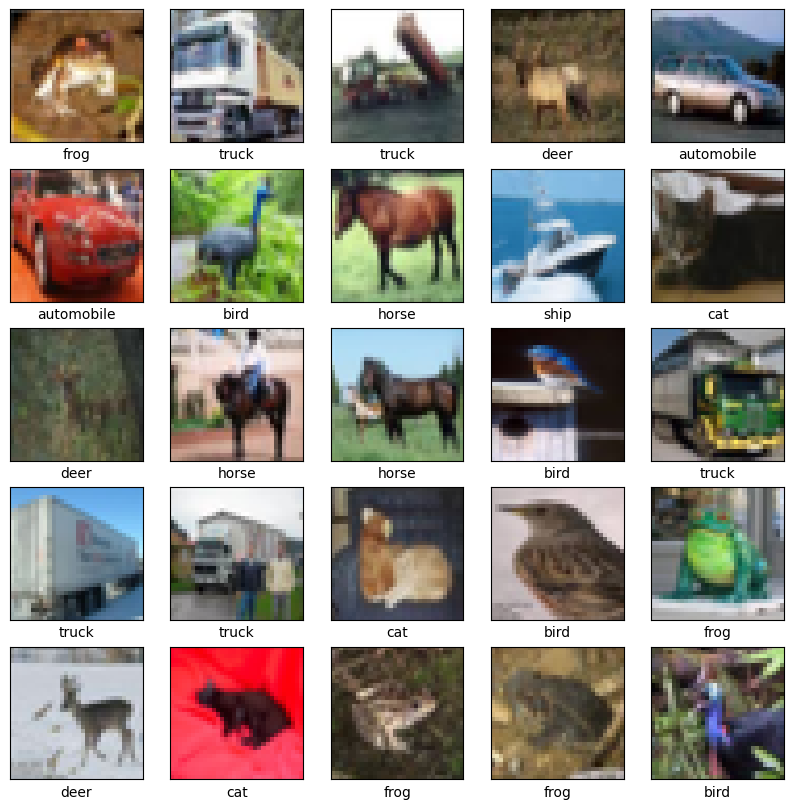

In [ ]:
#EDA for training data
perform_eda(train_images_eda, train_labels_eda, "CIFAR-10 Training")


Class distribution for CIFAR-10 Test set:
  - airplane: 1000 samples
  - automobile: 1000 samples
  - bird: 1000 samples
  - cat: 1000 samples
  - deer: 1000 samples
  - dog: 1000 samples
  - frog: 1000 samples
  - horse: 1000 samples
  - ship: 1000 samples
  - truck: 1000 samples


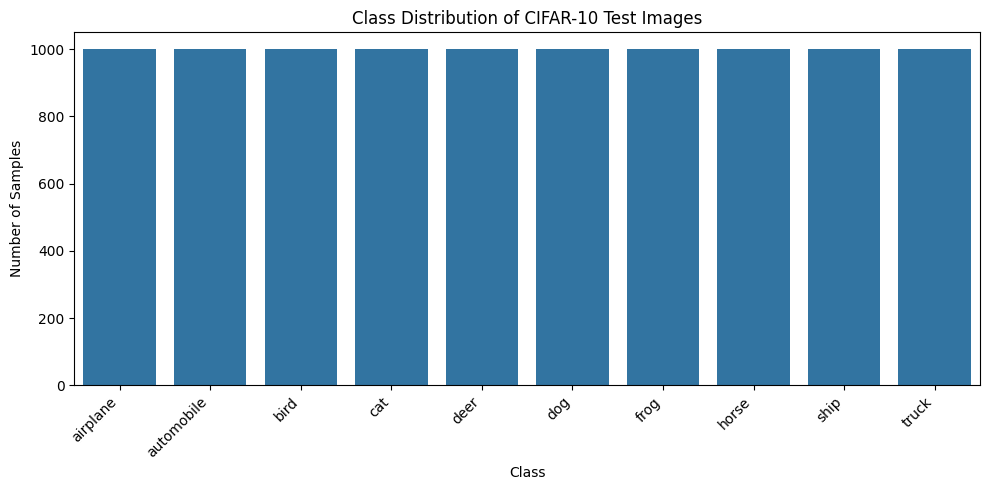


Plotting Pixel Intensity ... this will take time


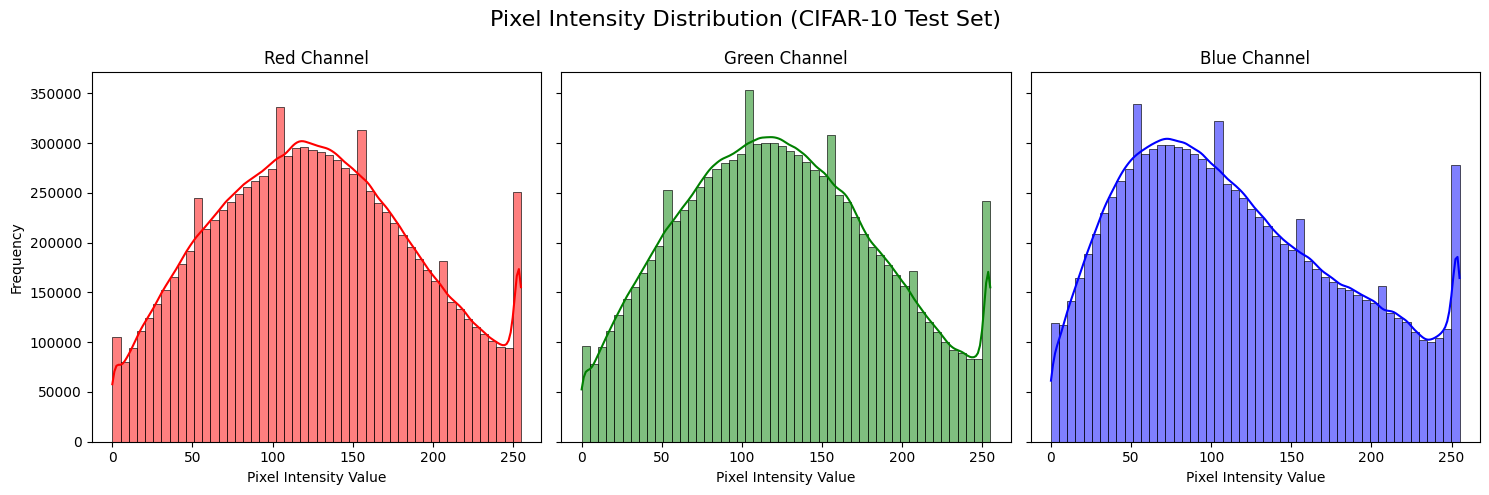


Displaying a sample of CIFAR-10 Test images:


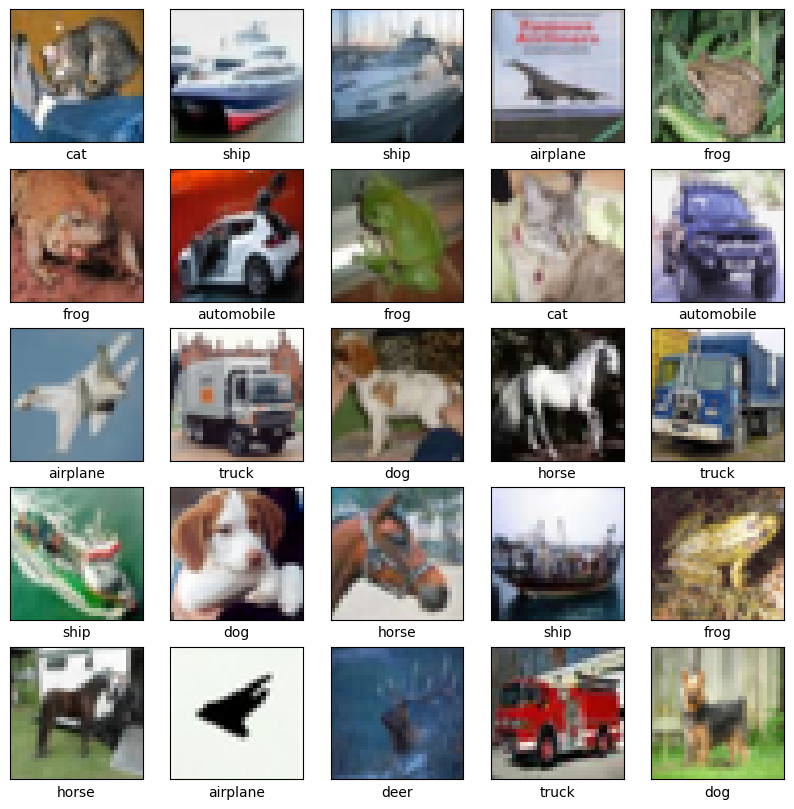

In [ ]:
perform_eda(test_images_eda, test_labels_eda, "CIFAR-10 Test")

### Data Setup for CINIC-10

To ensure that the project runs correctly, the file  **`custom_cinic10_data.zip`**  needs to be accessible.

#### **For Google Colab Users**:
If you are running this notebook on Google Colab,  upload `custom_cinic10_data.zip`  to your Colab environment in the `/content` folder before executing the following cell.

Important Note: If you run this cell multiple times then the '<i>-o</o>' option will overwrite the existing files. This shouldn't cause any issues.

After the unzip operation, you should see the following folders:

`data/custom_test_images_from_cinic10/test/airplane`
<br/>`data/custom_test_images_from_cinic10/test/automobile`
<br/>`data/custom_test_images_from_cinic10/test/bird`
<br/>`data/custom_test_images_from_cinic10/test/cat`
<br/>`data/custom_test_images_from_cinic10/test/deer`
<br/>`data/custom_test_images_from_cinic10/test/dog`
<br/>`data/custom_test_images_from_cinic10/test/frog`
<br/>`data/custom_test_images_from_cinic10/test/horse`
<br/>`data/custom_test_images_from_cinic10/test/ship`
<br/>`data/custom_test_images_from_cinic10/test/truck`
<br/>

The `/content` folder is cleaned up every time a new runtime is started or the CPU type is changed. Ensure that the file is unzippped before evaluating models.

<i>**Disclaimer**: This notebook was executed and validated using Google Colab Pro to leverage its enhanced computational resources. While the code is designed to be compatible with local environments, its functionality on a local machine has not been explicitly verified due to the extensive computational time required for training and evaluating these models.</i>

In [ ]:
# Unzip custom_cinic10_data.zip
!unzip -q -o custom_cinic10_data.zip

In [ ]:
#Read Custom CINIC-10 dataset

cinic_test_ds = tf.keras.utils.image_dataset_from_directory(
    CINIC_TEST_DIR,
    labels='inferred',
    label_mode='int',
    image_size=(32, 32),
    batch_size=1000,
    shuffle=False
)

# Helper function to convert tf.data.Dataset to NumPy arrays for EDA plotting
def dataset_to_numpy(dataset):
    images_list = []
    labels_list = []
    for images, labels in dataset:
        images_list.append(images.numpy())
        labels_list.append(labels.numpy())
    images_np = np.concatenate(images_list, axis=0)
    labels_np = np.concatenate(labels_list, axis=0)
    return images_np, labels_np.reshape(-1, 1)



Found 5000 files belonging to 10 classes.



Loading CINIC-10 test data into memory for EDA...

Class distribution for Custom data set - CINIC-10 Test set:
  - airplane: 500 samples
  - automobile: 500 samples
  - bird: 500 samples
  - cat: 500 samples
  - deer: 500 samples
  - dog: 500 samples
  - frog: 500 samples
  - horse: 500 samples
  - ship: 500 samples
  - truck: 500 samples


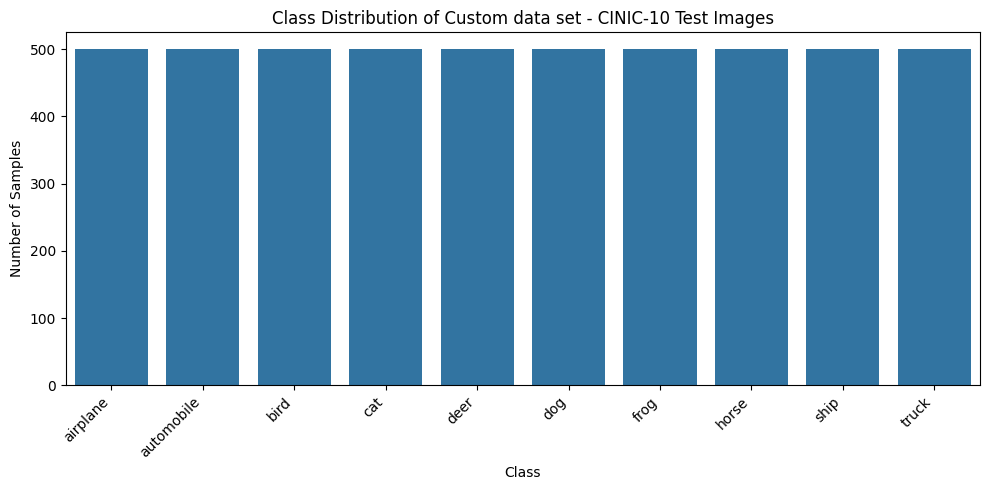


Plotting Pixel Intensity ... this will take time


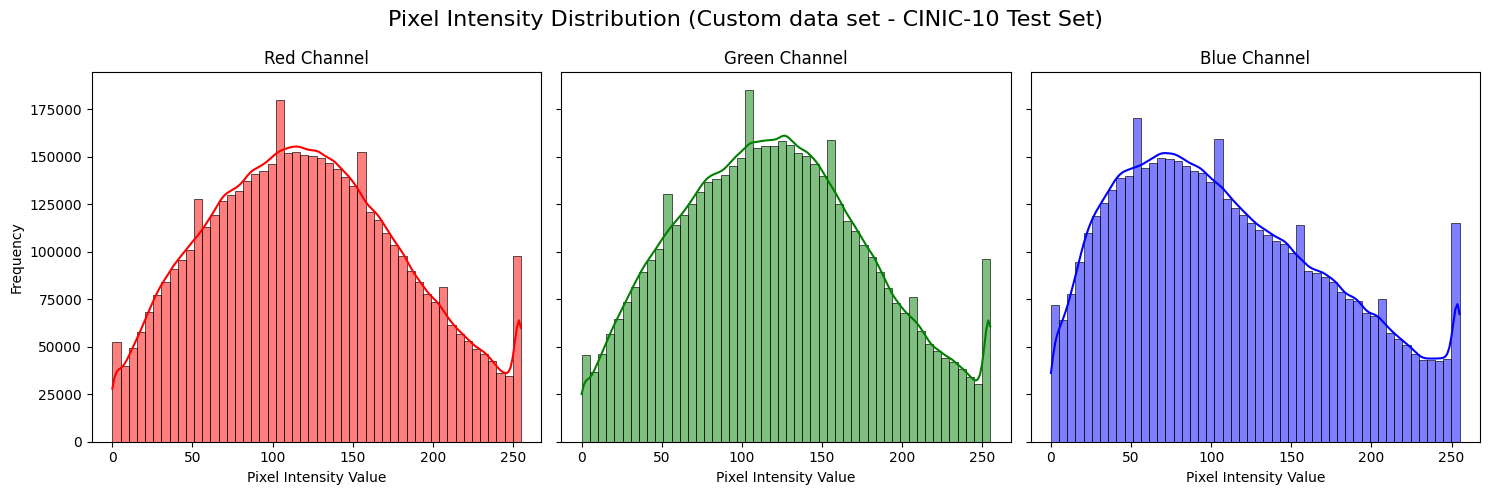


Displaying a sample of Custom data set - CINIC-10 Test images:


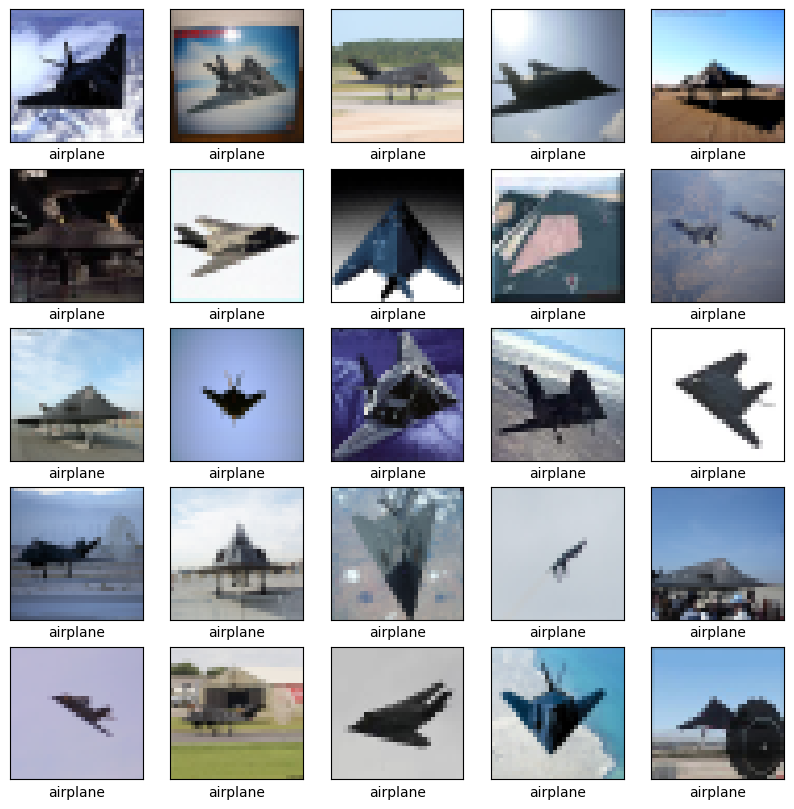

In [ ]:
print("\nLoading CINIC-10 test data into memory for EDA...")
cinic_test_images, cinic_test_labels = dataset_to_numpy(cinic_test_ds)
perform_eda(cinic_test_images, cinic_test_labels, "Custom data set - CINIC-10 Test")

### References

- [Pixel Intensity Histogram Characteristics: Basics of Image Processing and Machine Vision](https://www.allaboutcircuits.com/technical-articles/image-histogram-characteristics-machine-learning-image-processing/)
